<a href="https://colab.research.google.com/github/SyedAnasAli3/ATM/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SyedAnasAli3/Track

Cloning into 'Track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 11.87 MiB/s, done.
Checking out files: 100% (12160/12160), done.


# getting data from my git account.

In [ ]:
! ls Track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from imgaug import augmenters as iaa      #image augmentation augmenters
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath

Using TensorFlow backend.


In [ ]:
datadir = "Track"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

os module is used to join and retrive the actual file.
os.path.join(datadir, 'driving_log.csv') -> 1st argument is datadir=Track; 2nd argument is driving_log.csv =>so path becomes Track/driving_log.csv
display.max_colwidth : int or None(here -1 means all the chars displayed. )
    The maximum width in characters of a column in the repr of  
    a pandas data structure. When the column overflows, a "..."  
    placeholder is embedded in the output. A 'None' value means unlimited.  
    [default: 50] [currently: 50] 

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

ntpath module is used to split : here our images path is splitted to head and tail, returning the tail end for easier manipulation of our images.
data['center'].apply(path_leaf)-> dataframe series type-> so we can invoke by simply applying it via apply(), and it ll return the tail in every single value of our series.
Now our DATA is in CORRECT FORMAT.

# Below is where we balance data

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


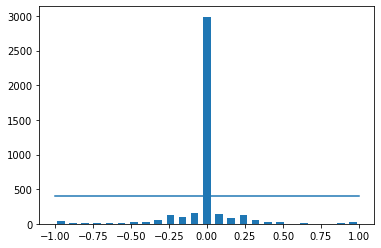

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])*0.5 
print(bins)
print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))

Plotting the steering angle on a histogram to visualise the ditribution and see the most frequent steering angles throughout the recording. Visualising is v.imp as it allows us to verify the flaws in our data for determining the steps need for preprocessing data for training.

HISTOGRAM CONSTRUCTION: 1) To divide the entire range of values into intervals, we re going to bin the range of values.num_bins (should be an odd number) as we aim to obtain a centered distribution.
2) np.histogram(data['steering'], num_bins) -> takes all the steering data and divide it in 25 bins(intervals).-> returns values of the histograms itself(called hist) and the 25 bin values (called bins[])

for centering our bins array at 0.00 we add two sliced segments of our bins array viz 1stsegment-> bins[:-1](zeroth index upto second last index) and 2ndsegment-> bins[1:](1st index to last).
ex: -1+-0.92 ; -0.92+-0.84;...-0.12+-0.04; -0.04+0.04; 0.04+0.12;......
resulting in a doubled array value so we multiply it by 0.5.
plt.bar(center, hist, width=0.05)->xValues=num_classes i.e center(bins[]) yvalues=frequency of each steering angle(viz.hist [])


to remove the biasness of straight driving viz 0 bin value-> rejecting all the samples above a certain threshold.(data uniformity)=200 samples.

To plot the threshold line :


In [ ]:
print(len(data['steering']))

4053


total data:  4053
removed :  2590
remaining :  1463


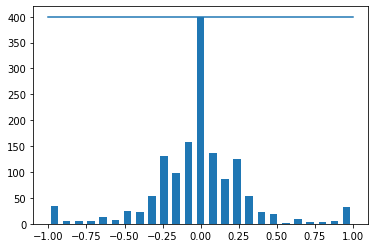

In [ ]:
print("total data: ", len(data))
remove_list = []
for j in range(num_bins):
  list_ = []#25 lists declared.
  for i in range(len(data['steering'])):    #5734 times.
   if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
     list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print("removed : ", len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("remaining : ",len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin, samples_per_bin))

for j in range we loop through every bin viz 25 bins from -0.96 to +0.96 runs 25 times.

for i in range #we ll loop through range of every single streering angle that was obtained throughout driving on the track , runs 5734 times

we now isolate the steering angles belonging to the current bin being iterated through 
if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: meaning if steering data which is iterated belongs to the current bin then append its index in the list_.
     list_.append(i)
modifications: after the inner for loop
Then shuffle the list and then remove the indexes in the remove_list remove_list.extend(list_) which allows us to spread the contents of what we want to dispose.

After this we drop all the indices from the dataframe (data) by the command:
data.drop(data.index[remove_list], inplace=True) inplace means call by refrence(actual params are changed).


# We gather the image paths and label values and thus splitting our training and validation data sets.

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering) 
  return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_44_413.jpg
left          left_2018_07_16_17_11_44_413.jpg
right        right_2018_07_16_17_11_44_413.jpg
steering                                 -0.05
throttle                              0.642727
reverse                                      0
speed                                  1.43401
Name: 12, dtype: object


indexed_data = data.iloc[i]-> it allows us to perform a selection on a row of data from our data frame based on the specified index(here i).
for now we are only going to work with the center images so we append all of them into the image path list. And inside the list while we place every single center image, we are also going to be appending into it the main path from the data dir that we pass in so we obtain the path: Track/IMG/center_2020....
This path allows us to access and reference all the images that we cloned from the repository. 

center.strip()->eliminates any spaces in between the names of center images.

next list we apend all the steering angles.

Now we have two arrays:
1) image_paths(images)  2) steerings.(image's corresponding labels)

In [ ]:
# Splitting into random training and validation data sets: USING train_test_split module from sklearn.models_selection
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size= 0.2, random_state=6)
print('Number of Training Samples: {}\nNumber of Validation Samples: {}'.format(len(X_train), len(X_valid)) )
print(X_train[100]) #image_paths contains

Number of Training Samples: 1170
Number of Validation Samples: 293
Track/IMG/center_2018_07_16_17_15_59_182.jpg


 test_size= 0.2, random_state=6{can be changed , as this is according to rayan's dataset. random_state= seed.}
 Now lets see both the dats have a uniform distribution viz., both left and right steering angles are balanced. so we are going to have two histograms using subplots()
 

Text(0.5, 1.0, 'Validation Set')

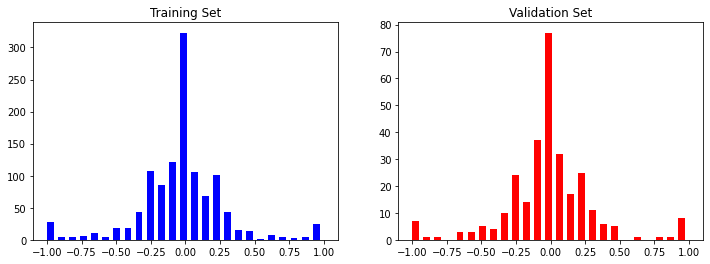

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue') 
axs[0].set_title('Training Set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color='red') 
axs[1].set_title('Validation Set')

Text(0.5, 1.0, 'Zoomed Image')

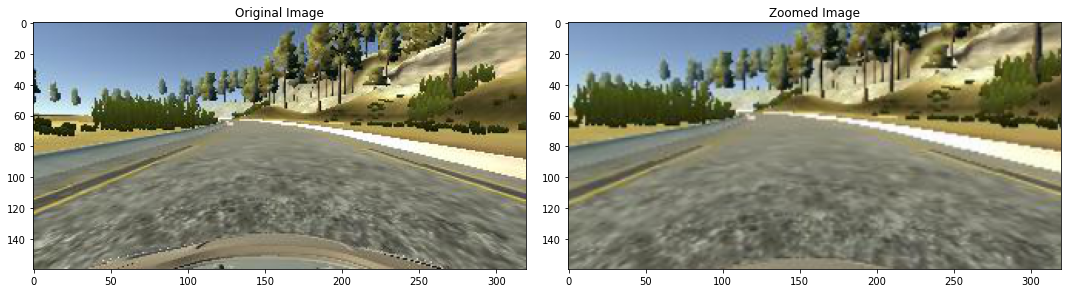

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)   #we read our image_path
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

#Augmentation 1)
Zoom statement is stored inside a function called **Affine**, Affine()-> deals explicitly with affine type transformations,viz. transformations which preserve straight lines and planes with the object.
scale=tuple(1{lowerlimit(here-nozoom)}, 1.3{upperlimit(30%zoomed)}), Zoom function itself will select a random percentage of zoom within our defined range for each new augmented image.
zoom.augment_image()->command to apply the zoom params to our image and augment it.

Text(0.5, 1.0, 'Panned Image')

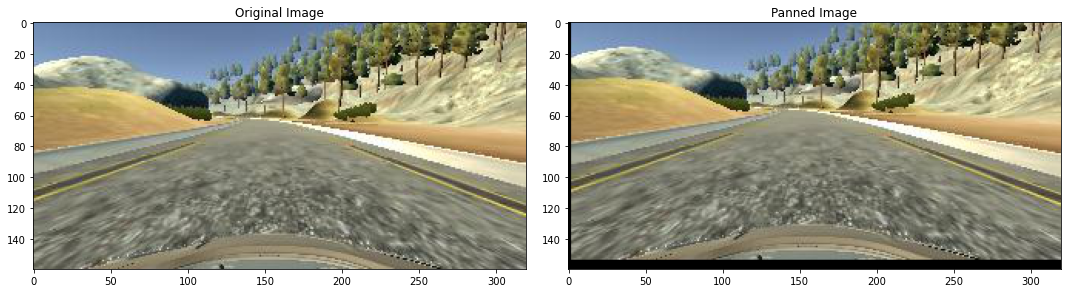

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" :(-0.1,0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)   
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

#Augmentation 2) Image Panning or translating
its the horizontal or vertical translation of the image.
we call the augmentation function which is stored in affine function. 
iaa.Affine(translate_percent= {"x" :(-0.1,0.1), "y": (-0.1, 0.1)}) which means x axis & y axis is panned/scrolled as +10%or-10%.

Text(0.5, 1.0, 'Brightness Altered Image')

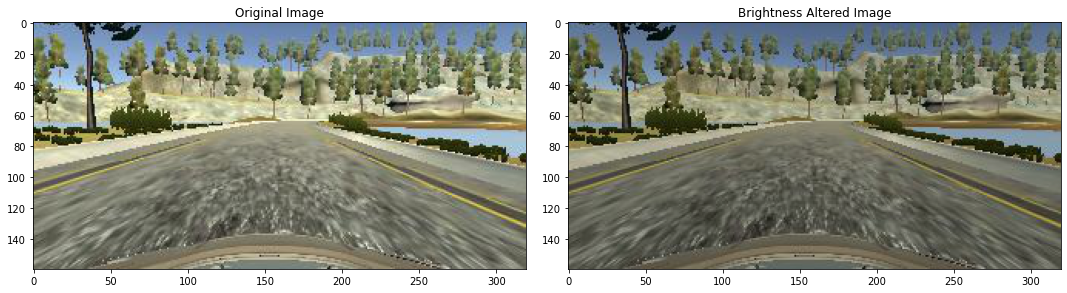

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')


#Augmentation 3) Altering brightness
The altered brightness function is called Multiply()-> it multiplies all the pixel intensities inside the image with a specific value. (multiplication by <1 =darker and >1 = lighter. From experience, we know the model responds better with darker images.range-> 0.2 to 1.2. 

Text(0.5, 1.0, 'Flipped Image- Steering Angle-0.1')

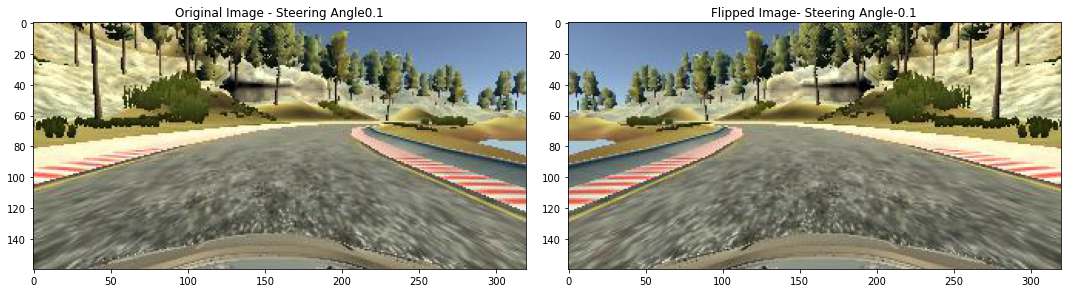

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image , 1)
  steering_angle = -steering_angle
  return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image- ' + 'Steering Angle' + str(flipped_steering_angle))

#Augmentation 4) Flipping:
Flipping can provide additional balancing. Opencv's function cv2.flip() is capable of flipping our image horizontally, vertically or a combination of both. {The 2nd argument is 0, 1, -1 => vertical, horizontal, or a commbination of both.}
When we flip our image horizontally, then our steering angle is also reversed hence we did above as well.
steerings[random_index]-> used when we defined load_img_steering()Function.

In [ ]:
def random_augment(image, steering_angle):    #two args->img_path and associated steering angle.
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:      # this loop runs 50% of the time.
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image) 
  if np.random.rand() < 0.5:
    image = img_random_brightness(image) 
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)    
  return image, steering_angle

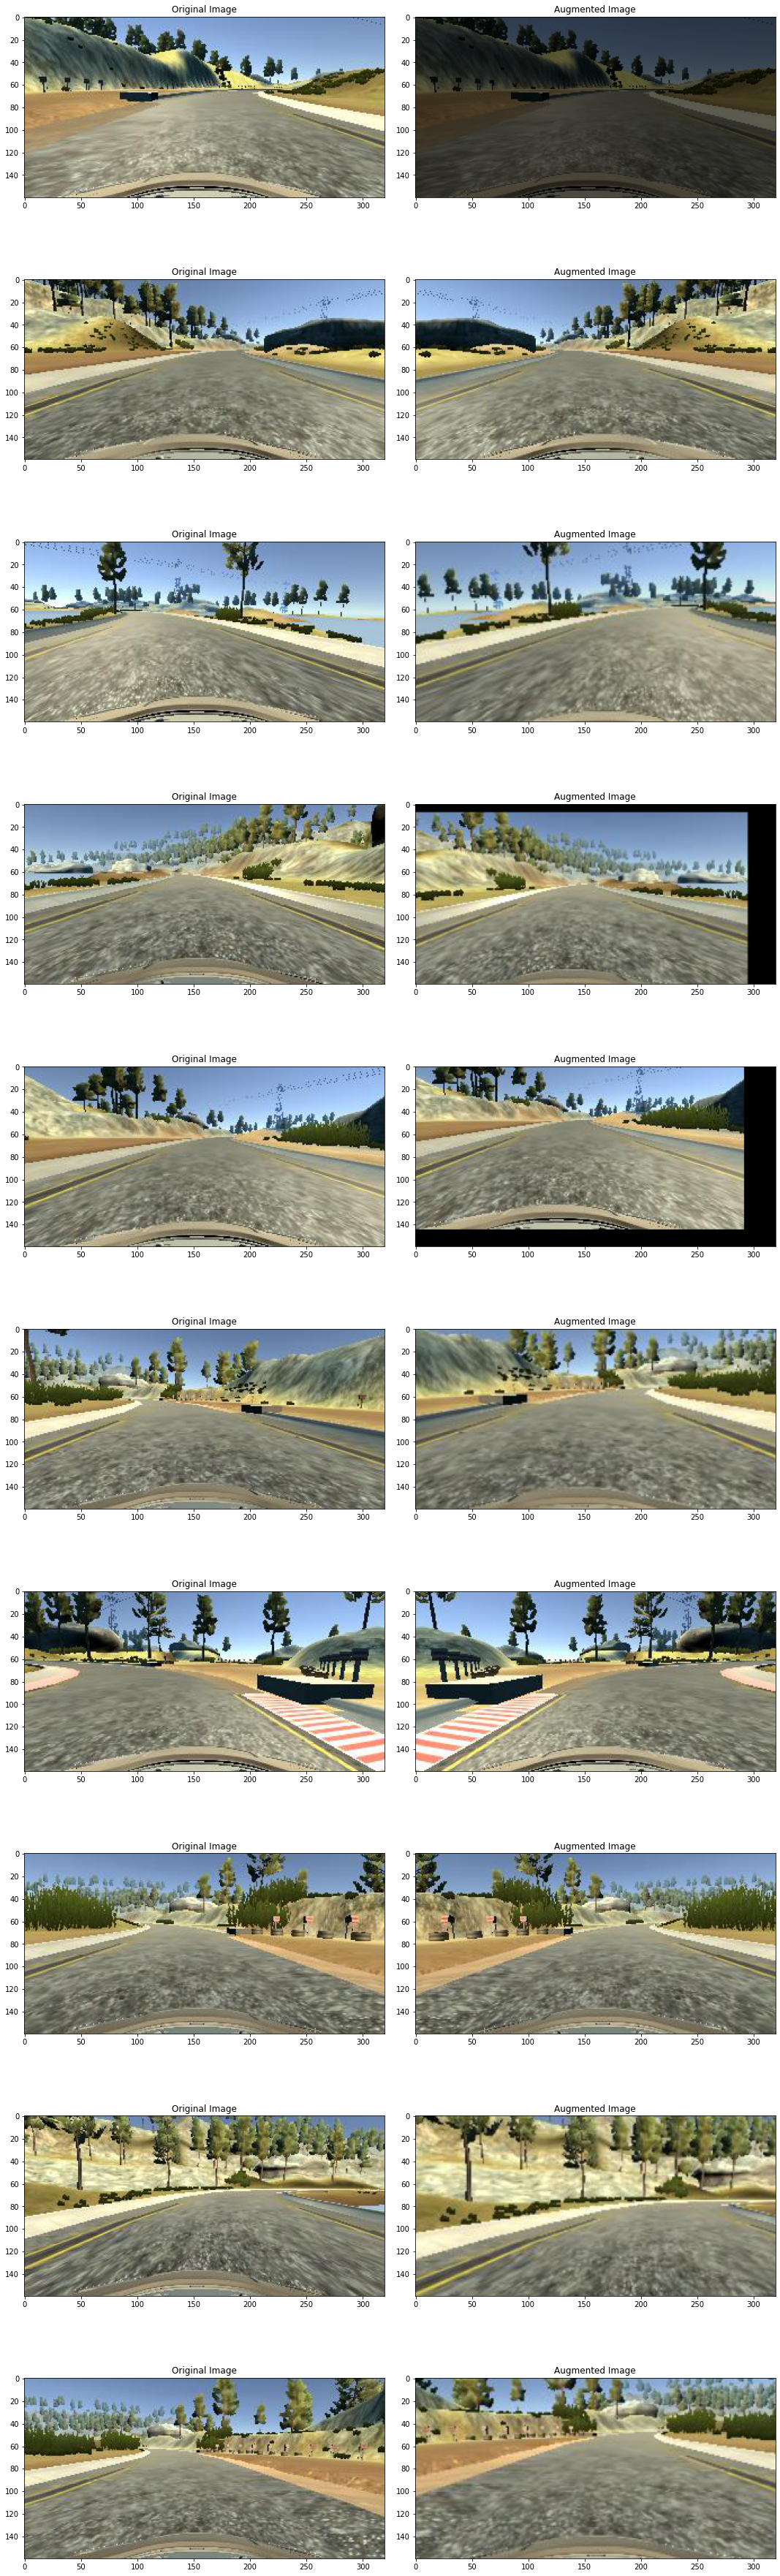

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image) 
  axs[i][1].set_title('Augmented Image')

#Randomisation of the occurence of these augmentations:
This is imp as we don't want each augmentation to be applied to each new image generated. Applying all the augmentations to every generated image actually reduces the overall variety of the new datasets. Combining the augmentations at random results in added variety in turn resulting into improved generalisation by our model. our code is such that every augmentation is allowed to run 50% of the time. Hence every augmentation will only be applied to 50% of the newly augmented images.
np.random.rand()-> returns random samples from a uniform distribution over the range 0to1.

# Preprocessing images

In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:] 
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)  #gaussian blur
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Function of matplotlib.img module as mpimg.imread()-> {Read an image from a file into an array.}argument passed is the img object containing the path of the image in the current directory Track. 
We ll convert or color space to YUV{Y=luminosity(brightness); UV= chrominance(adds color to the image)} cz NVIDIA model recommends us to use this color space.
Gaussian blur (here we use a kernel of (3,3) with 0 deviation as last argument)is useful to apply to an image to reduce noise which ll help us to easily extract features from our image.
Resizing images to make them smaller and matches the size of the images used by the NVIDIA model. 
Finally we normalize the images same as before we divide it by 255. to have a lower range of pixel representation. 

Text(0.5, 1.0, 'Preprocessed Image')

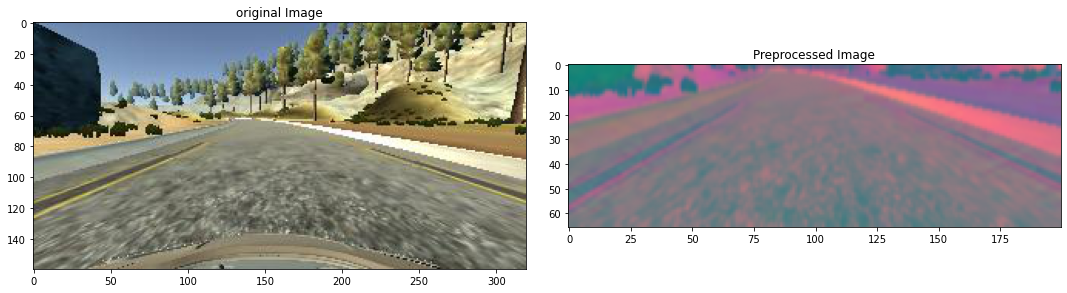

In [ ]:
#selecting a random image to visualise the differences between the preprocessed img and the original img:
image = image_paths[150]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_angl, batch_size, istraining):

  while True:  #loop ensures our generator runs continously and only stops momentarily during the yield statement
    batch_img = []
    batch_steering = [] 

    for i in range(batch_size):     #loop to augment images.
      random_index = random.randint(0, len(image_paths) - 1)  
      if istraining:  # for training process
        img, steering = random_augment(image_paths[random_index], steering_angl[random_index])
      else:   #for validation process
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angl[random_index]
      img = img_preprocess(img)           #img_preprocess function is called here cz of the memory benefits.
      batch_img.append(img)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))       #while loop will reset when the function is revisited.

#Batch Generator is a co-routine function.
A subroutine function after returning the final variable, all local variables get their values reassigned. Whereas a co-routine function after the yield statement doesn't allow the local variables to reassign their values and saves all the initalized values inside the generator. 
It can create Augmented images on the fly rather than augmenting all our images at one time and storing it using valuable memory space. it does so only when the generator is actually called. This is much more memory efficient as data is only used when its required.
Since fit() requires the entire dataset as a numpy array in memory, which is why for larger datasets we make use of fit_generator(),which generates augmented images on the fly in form of batches.
The variable istraining will only be true in case of training data, whereas in case of validation process this istraining variable will be set to False as our validation data should closely resemble the exact data that the car gets in simulation. 
Python Generators:
def generator_name():
  #statements
  yield something

Text(0.5, 1.0, 'Validation Image')

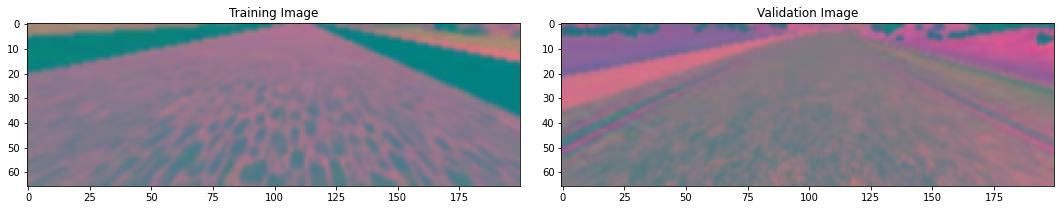

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 2, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

#now we can request some data from our generator
using the next()-> to request the next batch of images from our generator. it simply calls an iterator item and retrieves the next item for it. For ex.,
next(batch_generator(X_train, y_train, 1, 1)) #here batch_size=1 implies it will generate only 1 image(as instructed by our for loop) 


In [ ]:
# X_train = np.array(list(map(img_preprocess, X_train)))        #used when we dont used batch generator.
# X_valid = np.array(list(map(img_preprocess, X_valid)))
# print(X_valid.shape)

map() to run preprocessing function for each element of the image_paths!!
#we ll choose the neural architechture NVIDIA Model


In [ ]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1) ])   #used when we dont use batch generator
# plt.axis('off')
# print(X_train.shape)

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer= Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

dropout layers removed later cz of a large gap between the training and the validation losses plots.
Also the learning rate is reduced to 10^-4 from 10^-3 bcz our losses graph showed alot of ups and downs.

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=10,
                              validation_data = batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle=1) 

Epoch 1/10
300/300 [==============================] - 224s 745ms/step - loss: 0.0777 - val_loss: 0.0637
Epoch 2/10
300/300 [==============================] - 210s 701ms/step - loss: 0.0610 - val_loss: 0.0537
Epoch 3/10
300/300 [==============================] - 216s 720ms/step - loss: 0.0595 - val_loss: 0.0505
Epoch 4/10
300/300 [==============================] - 213s 711ms/step - loss: 0.0547 - val_loss: 0.0552
Epoch 5/10
300/300 [==============================] - 216s 720ms/step - loss: 0.0494 - val_loss: 0.0319
Epoch 6/10
300/300 [==============================] - 219s 729ms/step - loss: 0.0440 - val_loss: 0.0451
Epoch 7/10
300/300 [==============================] - 217s 722ms/step - loss: 0.0406 - val_loss: 0.0350
Epoch 8/10
300/300 [==============================] - 216s 721ms/step - loss: 0.0403 - val_loss: 0.0283
Epoch 9/10
300/300 [==============================] - 212s 707ms/step - loss: 0.0384 - val_loss: 0.0439
Epoch 10/10
300/300 [==============================] - 215s 716m

#model.fit is replaced with model.fit_generator:
Also our data is generated real time by our batch generator, hence we call it as well along with its arguments.NOTE:THE LAST ARGUMENT IN THE BATCH GENERATOR IS THE ISTRAINING ARGUMENT.
steps_per_epoch=300=> 100(batch_imgs) per step=>300x100=30000images per epoch.
With generator the images are created on the fly so it ll require less memory resources(so no problem).

Text(0.5, 0, 'Epochs')

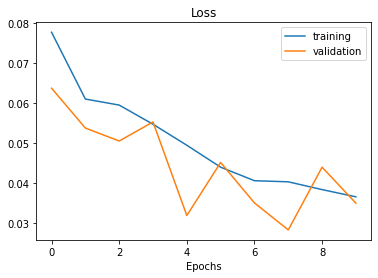

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model.h5')


In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>